In [1]:
import cv2
#from utils import *

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras import optimizers
from keras import backend as K

C:\Users\sudha\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
import os
import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
import pandas as pd

In [5]:
def load(test=False):
    FTRAIN = 'training/training.csv'
    FTEST = 'test/test.csv'
    
    filename = FTEST if test else FTRAIN

    df = read_csv(os.path.expanduser(filename))
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))
    cols = df.columns
    
    X = np.vstack(df['Image'].values)/255.

    if (test==False):
        y = df[df.columns[0:30]].values
        X = X[~ np.isnan(y).any(axis=1)]
        y = y[~ np.isnan(y).any(axis=1)]
        X, y = shuffle(X, y, random_state=42)
    else:
        y = None
        cols = None

    X = X.astype(np.float32)
    
    return X, y, cols

def load_2D(test=False):
    X, y, cols = load(test)
    X = X.reshape(-1, 96, 96, 1)
    
    return X, y, cols

In [6]:
# Load training data
X_train, y_train, label_cols = load_2D(test=False)


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [8]:
print("Train data shape: ", X_train.shape, " and Train label shape: ", y_train.shape)
print("Labels: ", label_cols[:-1])

Train data shape:  (1712, 96, 96, 1)  and Train label shape:  (1712, 30)
Labels:  Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')


In [9]:
print("Validation dataset shape: ", X_valid.shape, " and Validation label shape: ", y_valid.shape)

Validation dataset shape:  (428, 96, 96, 1)  and Validation label shape:  (428, 30)


In [10]:
# Load training data
X_test, y_test, label_cols = load_2D(test=True)


In [11]:
print("Test data shape: ", X_test.shape, " and Test label shape: ", y_test)
print("Labels: ", label_cols)

Test data shape:  (1783, 96, 96, 1)  and Test label shape:  None
Labels:  None


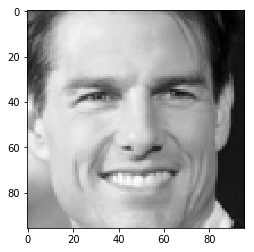

In [12]:
plt.imshow(X_train[1].reshape(96,96), cmap='gray')

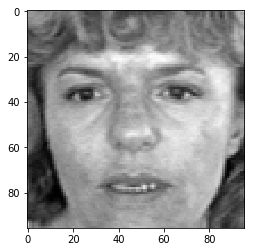

In [13]:
plt.imshow(X_valid[1].reshape(96,96), cmap='gray')

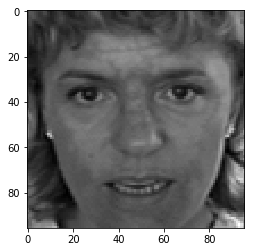

In [16]:
plt.imshow(X_test[1].reshape(96,96), cmap='gray')

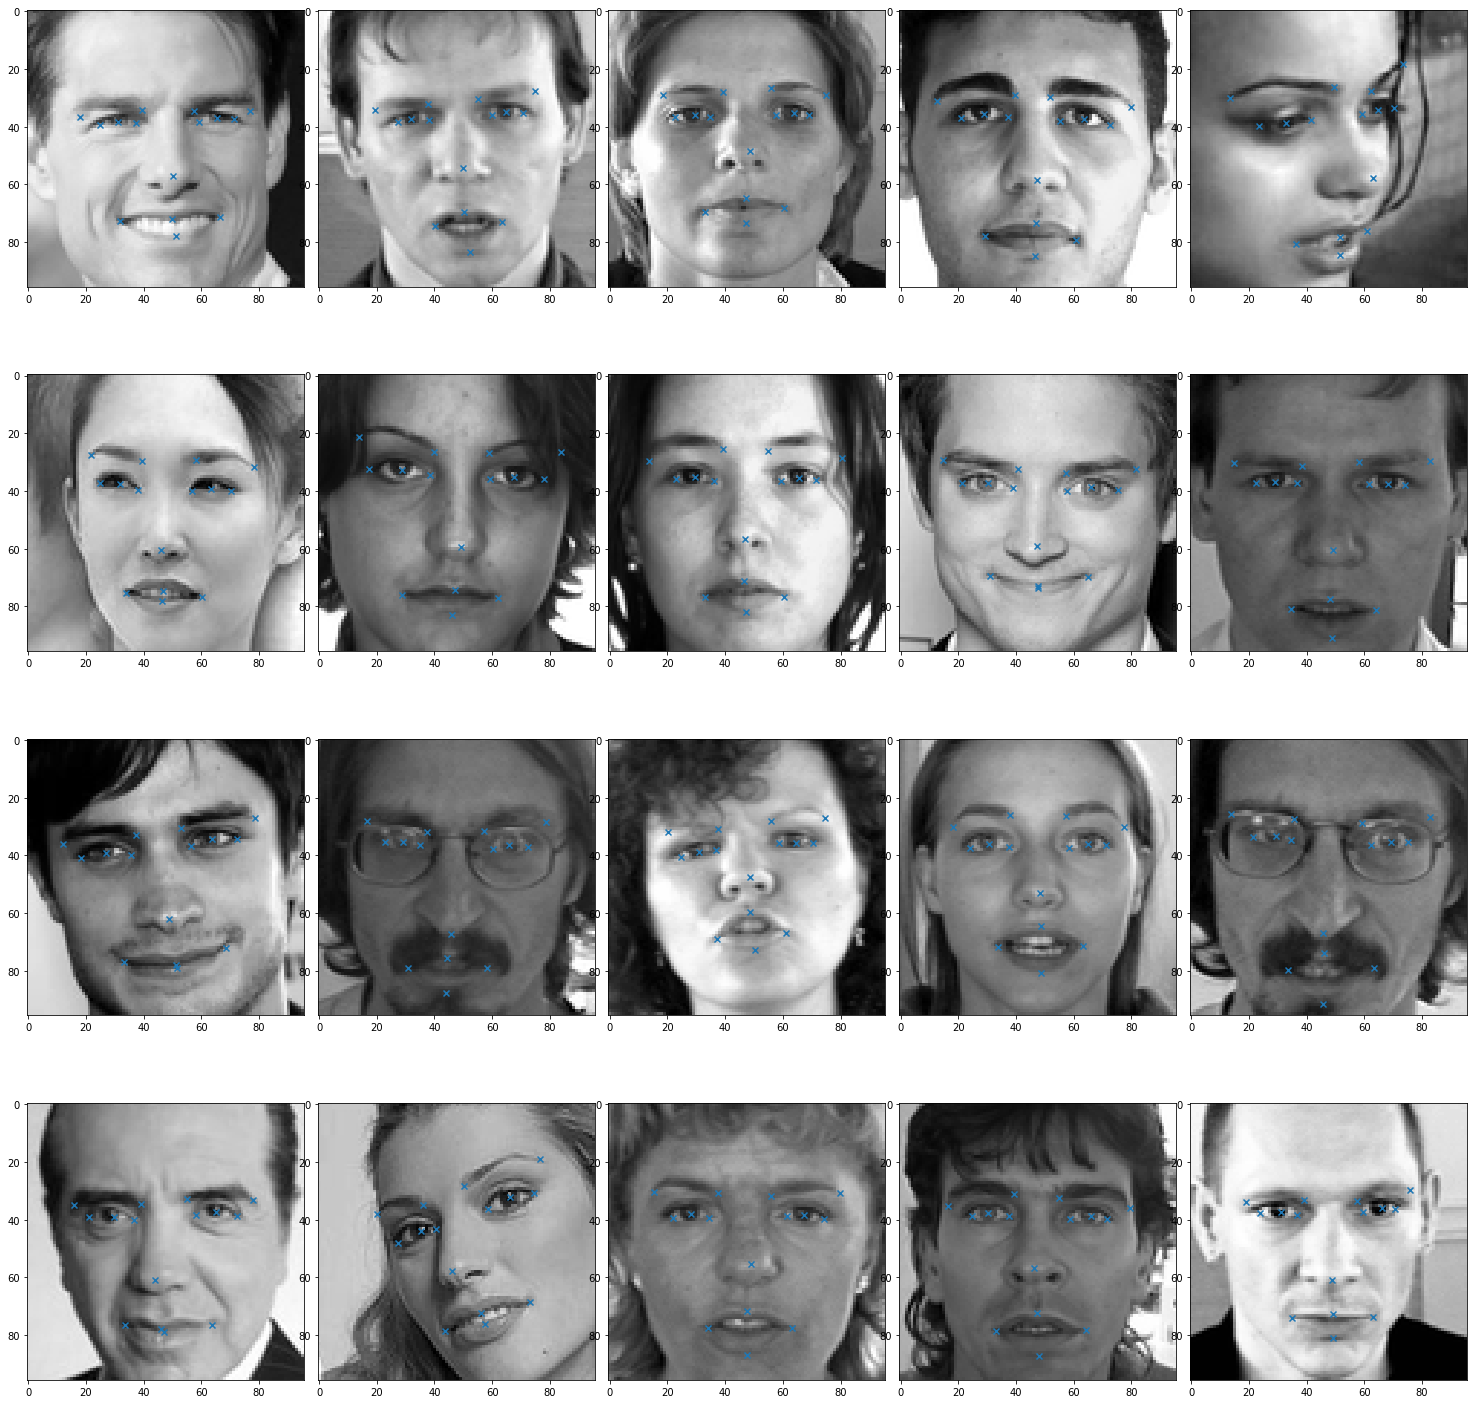

In [18]:
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(1,21):
    plt.subplot(4, 5, i)
    plt.imshow(X_train[i, :, :, 0].reshape(96,96), cmap='gray')
    plt.scatter(y_train[i, range(0,30,2)], y_train[i, range(1,30,2)], marker='x')
    
plt.show()

In [19]:
print(X_train[0].shape)
y_train[0].shape

(96, 96, 1)


(30,)

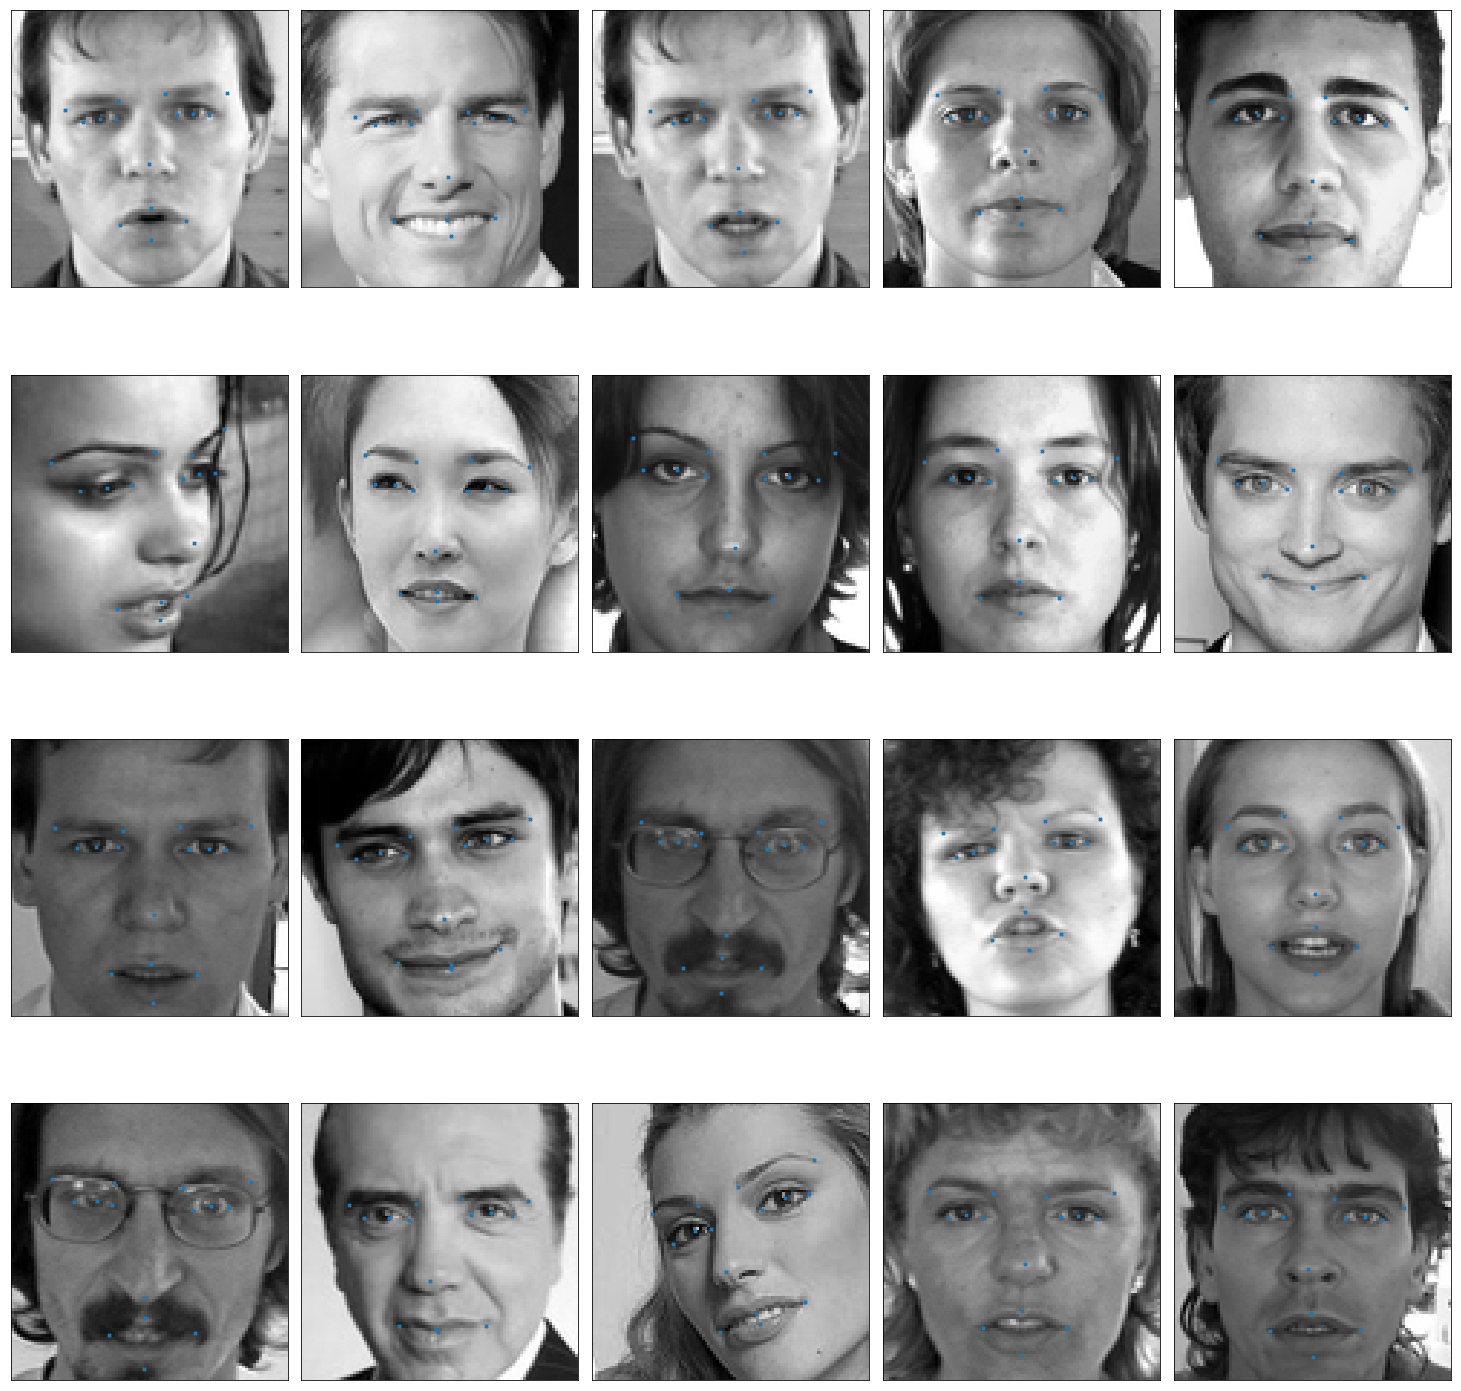

In [14]:
def plot_img(x, y, axis):
    img = x.reshape(96,96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2], y[1::2], marker='X', s=10)

fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(0,20):
    ax = fig.add_subplot(4,5,i+1, xticks=[], yticks=[])
    plot_img(X_train[i], y_train[i], ax)
    
plt.show()

## Train Convolutional Neural Network

In [23]:
from keras import backend as K

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# coefficient of determination (R^2) for regression  (only for Keras tensors)
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Model definition
model = Sequential()

# Add layers
model.add(BatchNormalization(input_shape=(96,96,1)))

model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(96,96,1), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(filters=48, kernel_size=(3,3)) )
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(filters=64, kernel_size=(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Flatten())

model.add(Dense(300))
model.add(Activation("relu"))

model.add(Dense(100))
model.add(Activation("relu"))

model.add(Dense(30))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[rmse, 'accuracy', 'mae', r_square])
#model.compile(optimizer='adam', loss=rmse, metrics=['accuracy', rmse])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, 96, 96, 1)         4         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 96, 96, 32)        320       
_________________________________________________________________
activation_6 (Activation)    (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 46, 46, 48)        13872     
_________________________________________________________________
activation_7 (Activation)    (None, 46, 46, 48)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 23, 23, 48)        0         
__________

In [24]:
%time res = model.fit(X_train, y_train, epochs=5, batch_size=100, validation_split=0, validation_data=(X_valid, y_valid), verbose=2)

Train on 1712 samples, validate on 428 samples
Epoch 1/5
 - 24s - loss: 1347.2559 - rmse: 35.2690 - acc: 0.0058 - mean_absolute_error: 30.0062 - r_square: -2.8084e+00 - val_loss: 442.9841 - val_rmse: 21.0345 - val_acc: 0.6916 - val_mean_absolute_error: 15.6251 - val_r_square: -2.5046e-01
Epoch 2/5
 - 24s - loss: 210.0364 - rmse: 14.1373 - acc: 0.4725 - mean_absolute_error: 10.6502 - r_square: 0.4074 - val_loss: 102.6126 - val_rmse: 10.1233 - val_acc: 0.2593 - val_mean_absolute_error: 7.5053 - val_r_square: 0.7105
Epoch 3/5
 - 22s - loss: 79.3113 - rmse: 8.8831 - acc: 0.4007 - mean_absolute_error: 6.6398 - r_square: 0.7762 - val_loss: 64.0982 - val_rmse: 8.0007 - val_acc: 0.6916 - val_mean_absolute_error: 6.0055 - val_r_square: 0.8192
Epoch 4/5
 - 22s - loss: 52.1695 - rmse: 7.2034 - acc: 0.7085 - mean_absolute_error: 5.3496 - r_square: 0.8530 - val_loss: 40.8486 - val_rmse: 6.3867 - val_acc: 0.6916 - val_mean_absolute_error: 4.7095 - val_r_square: 0.8847
Epoch 5/5
 - 22s - loss: 37.836

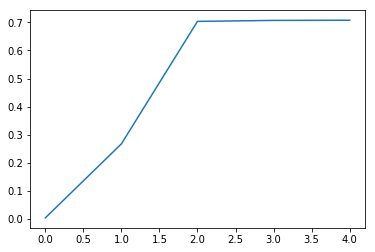

In [152]:
plt.plot(res.history['acc'])

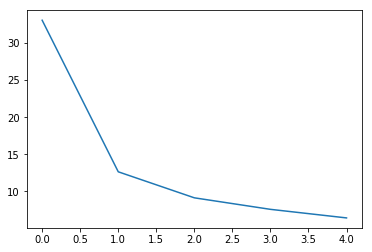

In [153]:
plt.plot(res.history['rmse'])

## CNN - using 'rmsprop' as Optimizer

In [154]:
from keras import backend as K

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

#    return np.sqrt(np.mean((y_true - y_pred) ** 2))
    
model = Sequential()

model.add(BatchNormalization(input_shape=(96,96,1)))

model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(96,96,1), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(filters=48, kernel_size=(3,3)) )
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(filters=64, kernel_size=(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Flatten())

model.add(Dense(300))
model.add(Activation("relu"))

model.add(Dense(100))
model.add(Activation("relu"))

model.add(Dense(30))
model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=[rmse, 'accuracy', 'mae'])
#model.compile(optimizer='adam', loss=rmse, metrics=['accuracy', rmse])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_16 (Batc (None, 96, 96, 1)         4         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 96, 96, 32)        320       
_________________________________________________________________
activation_72 (Activation)   (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 46, 46, 48)        13872     
_________________________________________________________________
activation_73 (Activation)   (None, 46, 46, 48)        0         
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 23, 23, 48)        0         
__________

In [155]:
%time res = model.fit(X_train, y_train, epochs=5, batch_size=100, validation_split=0.2, verbose=2)

Train on 1712 samples, validate on 428 samples
Epoch 1/5
 - 23s - loss: 735.2692 - rmse: 23.9101 - acc: 0.3335 - mean_absolute_error: 20.0053 - val_loss: 257.3682 - val_rmse: 16.0324 - val_acc: 0.6963 - val_mean_absolute_error: 13.1919
Epoch 2/5
 - 23s - loss: 220.8780 - rmse: 14.7327 - acc: 0.7074 - mean_absolute_error: 11.7562 - val_loss: 205.1158 - val_rmse: 14.3152 - val_acc: 0.6963 - val_mean_absolute_error: 12.0087
Epoch 3/5
 - 24s - loss: 189.7487 - rmse: 13.6256 - acc: 0.7074 - mean_absolute_error: 10.9658 - val_loss: 122.5237 - val_rmse: 11.0630 - val_acc: 0.6963 - val_mean_absolute_error: 8.8613
Epoch 4/5
 - 28s - loss: 183.7163 - rmse: 13.3872 - acc: 0.7074 - mean_absolute_error: 10.9187 - val_loss: 204.5469 - val_rmse: 14.2992 - val_acc: 0.6963 - val_mean_absolute_error: 12.2106
Epoch 5/5
 - 23s - loss: 162.8539 - rmse: 12.6210 - acc: 0.7074 - mean_absolute_error: 10.2159 - val_loss: 124.8202 - val_rmse: 11.1704 - val_acc: 0.6963 - val_mean_absolute_error: 9.0711
Wall time:

## CNN - Adam Optimizer; 

In [157]:
# updated back to 'Adam' optimizer; set 1st dense layer to 400 neurons

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

#    return np.sqrt(np.mean((y_true - y_pred) ** 2))
    
model = Sequential()

model.add(BatchNormalization(input_shape=(96,96,1)))

model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(96,96,1), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(filters=48, kernel_size=(3,3)) )
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(filters=64, kernel_size=(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Flatten())

model.add(Dense(400))
model.add(Activation("relu"))

model.add(Dense(100))
model.add(Activation("relu"))

model.add(Dense(30))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[rmse, 'accuracy', 'mae'])
#model.compile(optimizer='adam', loss=rmse, metrics=['accuracy', rmse])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_17 (Batc (None, 96, 96, 1)         4         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 96, 96, 32)        320       
_________________________________________________________________
activation_77 (Activation)   (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 46, 46, 48)        13872     
_________________________________________________________________
activation_78 (Activation)   (None, 46, 46, 48)        0         
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 23, 23, 48)        0         
__________

In [158]:
%time res = model.fit(X_train, y_train, epochs=5, batch_size=100, validation_split=0.2, verbose=2)

Train on 1712 samples, validate on 428 samples
Epoch 1/5
 - 24s - loss: 989.2047 - rmse: 28.6068 - acc: 0.2103 - mean_absolute_error: 24.2803 - val_loss: 176.3235 - val_rmse: 13.2720 - val_acc: 0.3084 - val_mean_absolute_error: 10.0334
Epoch 2/5
 - 23s - loss: 126.5470 - rmse: 11.1830 - acc: 0.3540 - mean_absolute_error: 8.6261 - val_loss: 84.7751 - val_rmse: 9.1981 - val_acc: 0.6963 - val_mean_absolute_error: 6.8736
Epoch 3/5
 - 24s - loss: 67.9445 - rmse: 8.1779 - acc: 0.7074 - mean_absolute_error: 6.1635 - val_loss: 52.4019 - val_rmse: 7.2269 - val_acc: 0.6963 - val_mean_absolute_error: 5.3600
Epoch 4/5
 - 27s - loss: 43.2026 - rmse: 6.5493 - acc: 0.7074 - mean_absolute_error: 4.8926 - val_loss: 40.3571 - val_rmse: 6.3282 - val_acc: 0.6963 - val_mean_absolute_error: 4.6331
Epoch 5/5
 - 25s - loss: 32.2165 - rmse: 5.6691 - acc: 0.7074 - mean_absolute_error: 4.2109 - val_loss: 35.4036 - val_rmse: 5.9335 - val_acc: 0.6963 - val_mean_absolute_error: 4.3748
Wall time: 2min 4s


## Add Dropout Layer

In [159]:
# updated back to 'Adam' optimizer; set 1st dense layer to 400 neurons

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

#    return np.sqrt(np.mean((y_true - y_pred) ** 2))
    
model = Sequential()

model.add(BatchNormalization(input_shape=(96,96,1)))

model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(96,96,1), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(filters=48, kernel_size=(3,3)) )
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(filters=64, kernel_size=(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Flatten())

model.add(Dense(400))
model.add(Activation("relu"))

model.add(Dense(100))
model.add(Activation("relu"))

# Add dropout layer to address overfitting issues
model.add(Dropout(0.3))

model.add(Dense(30))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[rmse, 'accuracy', 'mae'])
#model.compile(optimizer='adam', loss=rmse, metrics=['accuracy', rmse])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_18 (Batc (None, 96, 96, 1)         4         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 96, 96, 32)        320       
_________________________________________________________________
activation_82 (Activation)   (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 46, 46, 48)        13872     
_________________________________________________________________
activation_83 (Activation)   (None, 46, 46, 48)        0         
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 23, 23, 48)        0         
__________

In [161]:
%time res = model.fit(X_train, y_train, epochs=15, batch_size=200, validation_split=0.2, verbose=2)

Train on 1712 samples, validate on 428 samples
Epoch 1/15
 - 25s - loss: 188.3176 - rmse: 13.7187 - acc: 0.2973 - mean_absolute_error: 10.6898 - val_loss: 40.6159 - val_rmse: 6.3558 - val_acc: 0.6963 - val_mean_absolute_error: 4.6877
Epoch 2/15
 - 24s - loss: 175.8321 - rmse: 13.2539 - acc: 0.2862 - mean_absolute_error: 10.3627 - val_loss: 40.2040 - val_rmse: 6.3337 - val_acc: 0.6963 - val_mean_absolute_error: 4.6790
Epoch 3/15
 - 24s - loss: 164.2099 - rmse: 12.8122 - acc: 0.2979 - mean_absolute_error: 9.9847 - val_loss: 45.8625 - val_rmse: 6.7689 - val_acc: 0.6963 - val_mean_absolute_error: 5.0499
Epoch 4/15
 - 25s - loss: 157.5233 - rmse: 12.5445 - acc: 0.3201 - mean_absolute_error: 9.7441 - val_loss: 31.0761 - val_rmse: 5.5621 - val_acc: 0.6963 - val_mean_absolute_error: 4.1254
Epoch 5/15
 - 23s - loss: 150.9642 - rmse: 12.2826 - acc: 0.3067 - mean_absolute_error: 9.5862 - val_loss: 33.8873 - val_rmse: 5.8161 - val_acc: 0.6963 - val_mean_absolute_error: 4.3057
Epoch 6/15
 - 25s - l

## Without Dropout Layer

In [162]:
# updated back to 'Adam' optimizer; set 1st dense layer to 400 neurons

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

#    return np.sqrt(np.mean((y_true - y_pred) ** 2))
    
model = Sequential()

model.add(BatchNormalization(input_shape=(96,96,1)))

model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(96,96,1), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(filters=48, kernel_size=(3,3)) )
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(filters=64, kernel_size=(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Flatten())

model.add(Dense(400))
model.add(Activation("relu"))

model.add(Dense(200))
model.add(Activation("relu"))

# Add dropout layer to address overfitting issues
#model.add(Dropout(0.3))

model.add(Dense(30))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[rmse, 'accuracy', 'mae'])
#model.compile(optimizer='adam', loss=rmse, metrics=['accuracy', rmse])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_19 (Batc (None, 96, 96, 1)         4         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 96, 96, 32)        320       
_________________________________________________________________
activation_87 (Activation)   (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 46, 46, 48)        13872     
_________________________________________________________________
activation_88 (Activation)   (None, 46, 46, 48)        0         
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 23, 23, 48)        0         
__________

In [163]:
%time res = model.fit(X_train, y_train, epochs=50, batch_size=200, validation_split=0.2, verbose=2)

Train on 1712 samples, validate on 428 samples
Epoch 1/50
 - 25s - loss: 1725.6577 - rmse: 40.3767 - acc: 0.0000e+00 - mean_absolute_error: 36.2302 - val_loss: 452.1836 - val_rmse: 21.2546 - val_acc: 0.0000e+00 - val_mean_absolute_error: 16.2170
Epoch 2/50
 - 25s - loss: 271.5662 - rmse: 16.3289 - acc: 0.0403 - mean_absolute_error: 13.0012 - val_loss: 261.0379 - val_rmse: 16.1476 - val_acc: 0.0187 - val_mean_absolute_error: 11.9539
Epoch 3/50
 - 23s - loss: 181.4267 - rmse: 13.3692 - acc: 0.3405 - mean_absolute_error: 10.3641 - val_loss: 114.5201 - val_rmse: 10.6943 - val_acc: 0.6963 - val_mean_absolute_error: 8.1335
Epoch 4/50
 - 24s - loss: 114.1115 - rmse: 10.6730 - acc: 0.7074 - mean_absolute_error: 8.0971 - val_loss: 99.1819 - val_rmse: 9.9535 - val_acc: 0.6963 - val_mean_absolute_error: 7.6700
Epoch 5/50
 - 26s - loss: 86.9223 - rmse: 9.3015 - acc: 0.7074 - mean_absolute_error: 6.9725 - val_loss: 81.6009 - val_rmse: 9.0295 - val_acc: 0.6963 - val_mean_absolute_error: 6.8517
Epoch

 - 24s - loss: 8.9057 - rmse: 2.9811 - acc: 0.7074 - mean_absolute_error: 2.1780 - val_loss: 9.0407 - val_rmse: 3.0046 - val_acc: 0.6963 - val_mean_absolute_error: 2.2262
Epoch 46/50
 - 26s - loss: 8.7279 - rmse: 2.9535 - acc: 0.7074 - mean_absolute_error: 2.1519 - val_loss: 9.1402 - val_rmse: 3.0211 - val_acc: 0.6963 - val_mean_absolute_error: 2.2411
Epoch 47/50
 - 28s - loss: 8.6517 - rmse: 2.9402 - acc: 0.7074 - mean_absolute_error: 2.1391 - val_loss: 8.8126 - val_rmse: 2.9661 - val_acc: 0.6963 - val_mean_absolute_error: 2.1939
Epoch 48/50
 - 24s - loss: 8.6787 - rmse: 2.9448 - acc: 0.7074 - mean_absolute_error: 2.1506 - val_loss: 9.7105 - val_rmse: 3.1133 - val_acc: 0.6963 - val_mean_absolute_error: 2.3162
Epoch 49/50
 - 23s - loss: 8.9367 - rmse: 2.9868 - acc: 0.7074 - mean_absolute_error: 2.1907 - val_loss: 8.8045 - val_rmse: 2.9650 - val_acc: 0.6963 - val_mean_absolute_error: 2.1951
Epoch 50/50
 - 24s - loss: 8.5072 - rmse: 2.9152 - acc: 0.7074 - mean_absolute_error: 2.1244 - va

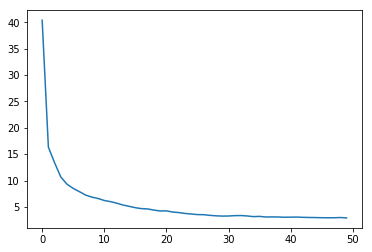

In [164]:
plt.plot(res.history['rmse'])

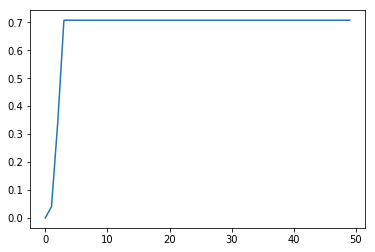

In [165]:
plt.plot(res.history['acc'])

## Conv2D layers with filters 32,64 and 64

In [13]:
# updated back to 'Adam' optimizer; set 1st dense layer to 400 neurons

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

#    return np.sqrt(np.mean((y_true - y_pred) ** 2))
    
model = Sequential()

model.add(BatchNormalization(input_shape=(96,96,1)))

model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(96,96,1), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=1, padding='valid'))

model.add(Conv2D(filters=64, kernel_size=(3,3)) )
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=1, padding='valid'))

model.add(Conv2D(filters=64, kernel_size=(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=1, padding='valid'))

model.add(Flatten())

model.add(Dense(400))
model.add(Activation("relu"))

model.add(Dense(100))
model.add(Activation("relu"))

# Add dropout layer to address overfitting issues
#model.add(Dropout(0.3))

model.add(Dense(30))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[rmse, 'accuracy', 'mae'])
#model.compile(optimizer='adam', loss=rmse, metrics=['accuracy', rmse])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 96, 96, 1)         4         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 95, 95, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 93, 93, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 93, 93, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 92, 92, 64)        0         
__________

In [14]:
%time res = model.fit(X_train, y_train, epochs=20, batch_size=100, validation_split=0.2, verbose=2)

Train on 1712 samples, validate on 428 samples
Epoch 1/20
 - 273s - loss: 401.1056 - rmse: 16.5754 - acc: 0.6040 - mean_absolute_error: 13.5761 - val_loss: 70.6180 - val_rmse: 8.3941 - val_acc: 0.4019 - val_mean_absolute_error: 6.4930
Epoch 2/20
 - 240s - loss: 53.0904 - rmse: 7.1797 - acc: 0.6256 - mean_absolute_error: 5.4410 - val_loss: 34.9113 - val_rmse: 5.8980 - val_acc: 0.6963 - val_mean_absolute_error: 4.4647
Epoch 3/20
 - 246s - loss: 23.1953 - rmse: 4.7780 - acc: 0.7085 - mean_absolute_error: 3.5641 - val_loss: 37.9464 - val_rmse: 6.1538 - val_acc: 0.6963 - val_mean_absolute_error: 4.9383
Epoch 4/20
 - 242s - loss: 20.1623 - rmse: 4.3796 - acc: 0.7126 - mean_absolute_error: 3.3119 - val_loss: 17.3019 - val_rmse: 4.1555 - val_acc: 0.6963 - val_mean_absolute_error: 3.1220
Epoch 5/20
 - 238s - loss: 11.0623 - rmse: 3.3011 - acc: 0.7144 - mean_absolute_error: 2.4247 - val_loss: 10.0414 - val_rmse: 3.1641 - val_acc: 0.6939 - val_mean_absolute_error: 2.3226
Epoch 6/20
 - 239s - loss

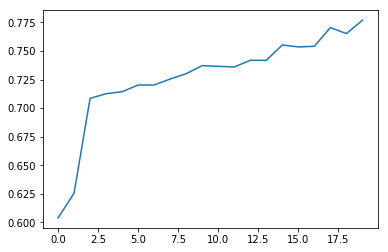

In [15]:
plt.plot(res.history['acc'])

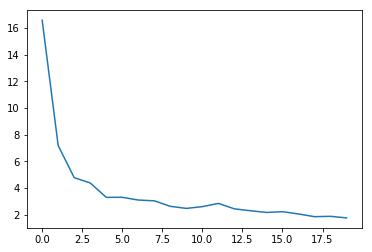

In [16]:
plt.plot(res.history['rmse'])

In [17]:
model.save('Sudha-FKP-Baseline-1.h5')

In [18]:
model.metrics_names

['loss', 'rmse', 'acc', 'mean_absolute_error']

In [21]:
from sklearn.datasets import make_regression

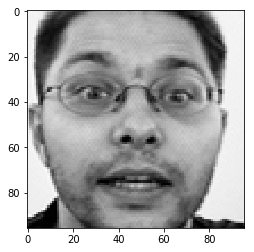

In [23]:
plt.imshow(X_test[0].reshape(96,96), cmap='gray')

In [27]:
# predicting labels for one example test image
predictions = model.predict(X_test[0].reshape(-1,96,96,1))

In [28]:
predictions

array([[62.54318 , 36.167217, 27.6334  , 35.250057, 57.833595, 36.208565,
        71.752495, 34.953987, 35.33265 , 35.944843, 21.781342, 36.2177  ,
        57.69956 , 24.834023, 77.18982 , 26.54589 , 36.70036 , 24.830496,
        15.387747, 25.122208, 47.05313 , 50.64009 , 62.558376, 72.48647 ,
        30.02574 , 70.96433 , 46.114784, 65.52386 , 46.856075, 80.84828 ]],
      dtype=float32)

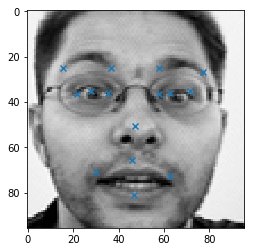

In [37]:
plt.imshow(X_test[0, :, :, 0].reshape(96,96), cmap='gray')
plt.scatter(predictions.reshape(30,)[range(0,30,2)], predictions.reshape(30,)[range(1,30,2)], marker='x')


In [38]:
y_test = model.predict(X_test)

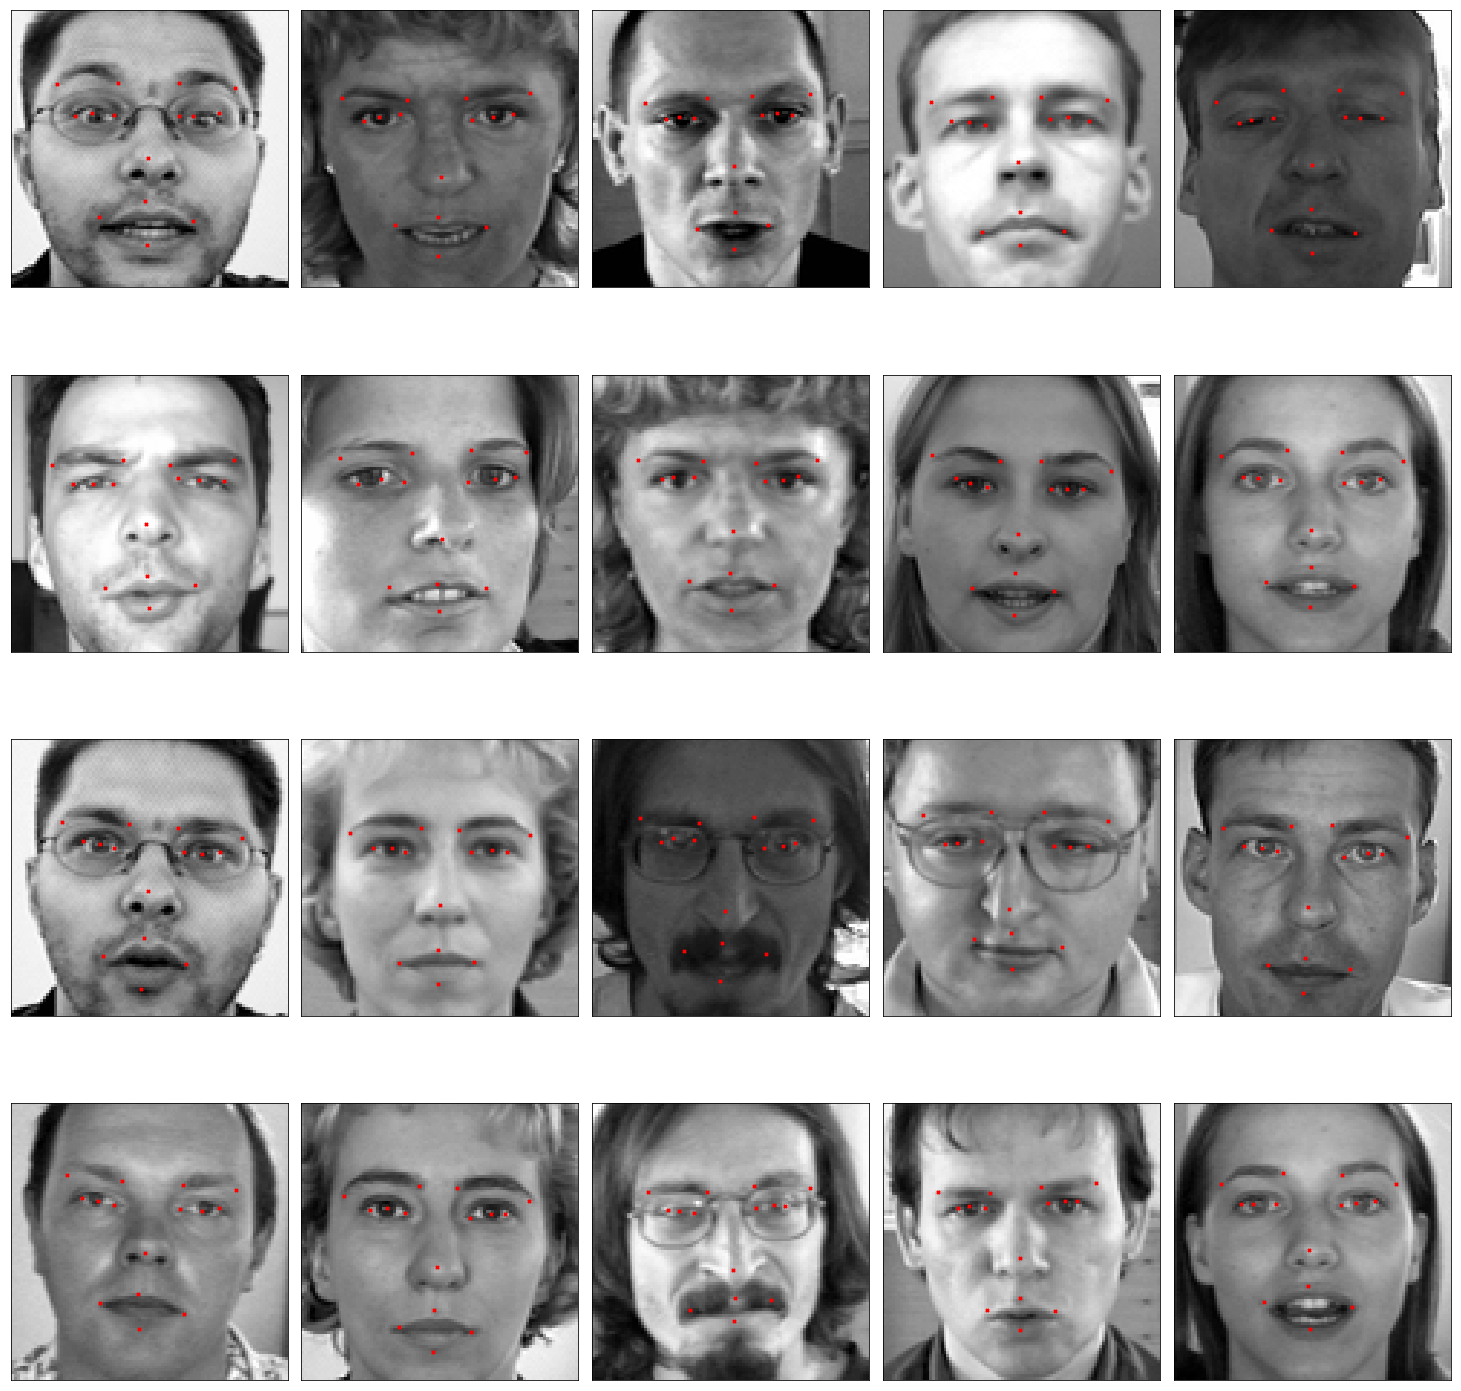

In [47]:
def plot_img(x, y, axis):
    img = x.reshape(96,96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2], y[1::2], marker='X', s=10, color='red')

fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(0,20):
    ax = fig.add_subplot(4,5,i+1, xticks=[], yticks=[])
    plot_img(X_test[i], y_test[i], ax)
    
plt.show()

## Use explicit Validation Dataset

In [15]:
# updated back to 'Adam' optimizer; set 1st dense layer to 400 neurons

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# coefficient of determination (R^2) for regression  (only for Keras tensors)
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Build model
model = Sequential()

# include batch normalization so image size is same across
model.add(BatchNormalization(input_shape=(96,96,1)))

# Add convolution layers, activation and MaxPooling
model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(96,96,1), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=1, padding='valid'))

model.add(Conv2D(filters=64, kernel_size=(3,3)) )
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=1, padding='valid'))

model.add(Conv2D(filters=64, kernel_size=(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=1, padding='valid'))

model.add(Flatten())

model.add(Dense(400))
model.add(Activation("relu"))

model.add(Dense(100))
model.add(Activation("relu"))

# Add dropout layer to address overfitting issues
#model.add(Dropout(0.3))

model.add(Dense(30))

# include custom metrics rmse and r_square
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[rmse, 'accuracy', 'mae', r_square])
#model.compile(optimizer='adam', loss=rmse, metrics=['accuracy', rmse])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 96, 96, 1)         4         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 95, 95, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 93, 93, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 93, 93, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 92, 92, 64)        0         
__________

In [16]:
%time res = model.fit(X_train, y_train, epochs=50, batch_size=100, validation_split=0, validation_data=(X_valid, y_valid), verbose=2)

Train on 1712 samples, validate on 428 samples
Epoch 1/50
 - 256s - loss: 397.4365 - rmse: 16.8015 - acc: 0.5012 - mean_absolute_error: 13.7258 - r_square: -1.2081e-01 - val_loss: 82.8167 - val_rmse: 9.0974 - val_acc: 0.2593 - val_mean_absolute_error: 6.6488 - val_r_square: 0.7663
Epoch 2/50
 - 225s - loss: 57.4143 - rmse: 7.5010 - acc: 0.4369 - mean_absolute_error: 5.6563 - r_square: 0.8383 - val_loss: 63.9357 - val_rmse: 7.9931 - val_acc: 0.6916 - val_mean_absolute_error: 6.3864 - val_r_square: 0.8195
Epoch 3/50
 - 224s - loss: 38.5679 - rmse: 6.0551 - acc: 0.7085 - mean_absolute_error: 4.6601 - r_square: 0.8911 - val_loss: 20.8608 - val_rmse: 4.5638 - val_acc: 0.6916 - val_mean_absolute_error: 3.3611 - val_r_square: 0.9411
Epoch 4/50
 - 224s - loss: 19.8398 - rmse: 4.4094 - acc: 0.7120 - mean_absolute_error: 3.3427 - r_square: 0.9440 - val_loss: 16.3981 - val_rmse: 4.0480 - val_acc: 0.6916 - val_mean_absolute_error: 3.0208 - val_r_square: 0.9537
Epoch 5/50
 - 225s - loss: 12.5426 - 

Epoch 37/50
 - 233s - loss: 1.3672 - rmse: 1.1516 - acc: 0.8984 - mean_absolute_error: 0.8859 - r_square: 0.9961 - val_loss: 3.6122 - val_rmse: 1.8967 - val_acc: 0.7593 - val_mean_absolute_error: 1.3165 - val_r_square: 0.9898
Epoch 38/50
 - 232s - loss: 1.1268 - rmse: 1.0579 - acc: 0.8960 - mean_absolute_error: 0.8010 - r_square: 0.9968 - val_loss: 3.5022 - val_rmse: 1.8666 - val_acc: 0.7593 - val_mean_absolute_error: 1.2730 - val_r_square: 0.9901
Epoch 39/50
 - 231s - loss: 0.9785 - rmse: 0.9863 - acc: 0.9048 - mean_absolute_error: 0.7427 - r_square: 0.9972 - val_loss: 3.4607 - val_rmse: 1.8563 - val_acc: 0.7570 - val_mean_absolute_error: 1.2733 - val_r_square: 0.9902
Epoch 40/50
 - 230s - loss: 1.1644 - rmse: 1.0695 - acc: 0.9077 - mean_absolute_error: 0.8183 - r_square: 0.9967 - val_loss: 3.3757 - val_rmse: 1.8334 - val_acc: 0.7570 - val_mean_absolute_error: 1.2382 - val_r_square: 0.9905
Epoch 41/50
 - 231s - loss: 0.8239 - rmse: 0.9056 - acc: 0.9106 - mean_absolute_error: 0.6767 - 

In [17]:
model.save('Sudha-FKP-v3.h5')

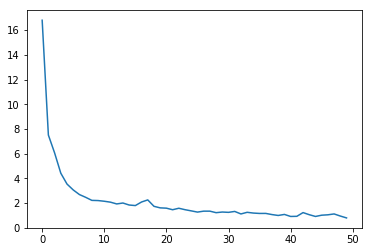

In [18]:
plt.plot(res.history['rmse'])

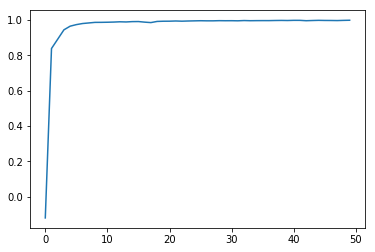

In [19]:
plt.plot(res.history['r_square'])

In [20]:
plt.plot(res.history['mae'])

KeyError: 'mae'